# Mount Drive

In [28]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri Dec  3 22:22:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    40W / 250W |   3881MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

# Function Library

Hyperparameters
1. Image Preprocessing
2. Batch Size
3. Optimizer
4. Add/Subtract layers in architecture

In [29]:
import torch
import numpy as np
import os, time, random, sys, math
import torch.optim as optim
import torch.nn as nn
import tqdm.notebook as tq
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score
import torchvision.models as models

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()


class PathDataset(torch.utils.data.Dataset):
  '''
    Torch data loading class.
    Arguments:
      img - numpy array of images
      label - Torch tensor of image labels
      transform - Torch composed transformations (default: resize to 64x64)
  '''
  def __init__(self, img, label, transform=None):
    self.X = img
    self.Y = label
    if transform:
      self.transform = transform
    else:
      self.transform = torchvision.transforms.Compose([transforms.ToPILImage(),
                                                       transforms.Resize((32, 32)),
                                                       transforms.ToTensor()])
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = self.transform(self.X[idx])
    return img, self.Y[idx]


def load_data(BATCH_SIZE):
  # load into numpy array
  images = np.load("/content/drive/MyDrive/pathmnist.npz")
  Xtrain = images["train_images"]
  Xval = images["val_images"]
  Xtest = images["test_images"]
  ytrain = torch.from_numpy(images["train_labels"].flatten()).long()
  yval = torch.from_numpy(images["val_labels"].flatten()).long()
  ytest = torch.from_numpy(images["test_labels"].flatten()).long()
  # load into dataset
  transform_train = torchvision.transforms.Compose([transforms.ToPILImage(),
                                              transforms.Resize((32, 32)),
                                              transforms.RandomVerticalFlip(0.5),
                                              transforms.RandomHorizontalFlip(0.5),
                                              transforms.ToTensor()])
  train_data = PathDataset(Xtrain, ytrain, transform_train)
  val_data = PathDataset(Xval, yval)
  test_data = PathDataset(Xtest, ytest)
  # load batches
  train_dl = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
  val_dl = DataLoader(val_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  test_dl = DataLoader(test_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  return train_dl, val_dl, test_dl

def calculate_accuracy(fx, y):
  preds = fx.max(1, keepdim=True)[1]
  correct = preds.eq(y.view_as(preds)).sum()
  acc = correct.float()/preds.shape[0]
  return acc

def train(model, device, iterator, optimizer, criterion, scheduler=None):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x, y) in tq.tqdm(iterator, leave=False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    fx = model(x)
    loss = criterion(fx, y)
    acc = calculate_accuracy(fx, y)
    loss.backward()
    optimizer.step()
    if scheduler:
      scheduler.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, device, iterator, criterion, scheduler=None):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in tq.tqdm(iterator, leave=False):
      x = x.to(device)
      y = y.to(device)
      fx = model(x)
      loss = criterion(fx, y)
      acc = calculate_accuracy(fx, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
    if scheduler:
      scheduler.step(epoch_loss/len(iterator))
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


# Model Training


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(num_classes=9)
model.to(device)
summary(model, (3, 64, 64))
'''
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99, nesterov=True, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=0.1,base_momentum=0.875, max_momentum=0.99, cycle_momentum=True)
'''
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
criterion = nn.CrossEntropyLoss()
EPOCHS = 50
MODEL_NAME = 'comp_med_resnet.pt'
SAVE_DIR = "drive/MyDrive/"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
train_iterator, val_iterator, test_iterator = load_data(BATCH_SIZE=1024)

best_valid_loss = float('inf')
time_curr = time.time()
history = dict()
# create save directory
if not os.path.isdir(f'{SAVE_DIR}'):
  os.makedirs(f'{SAVE_DIR}')
train_acc_list, val_acc_list, train_loss_list, val_loss_list = list(), list(), list(), list()

for epoch in range(EPOCHS):
  train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, device, val_iterator, criterion, scheduler)
  train_acc_list.append(train_acc)
  val_acc_list.append(valid_acc)
  train_loss_list.append(train_loss)
  val_loss_list.append(valid_loss)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

  print("|Epoch: {0:d} | Train loss: {1:.3f} | Train Acc: {2:.2f}% | Val Loss : {3:.3f} | Val Acc: {4:.2f}% | Time used: {5:d}s |".format(epoch+1,
      train_loss, train_acc*100, valid_loss, valid_acc*100, int(time.time()-time_curr)))
  history[epoch] = [train_loss, valid_loss]

  time_curr = time.time()

train_acc_list = np.array(train_acc_list)
val_acc_list = np.array(val_acc_list)
train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
np.save("train_acc_list", train_acc_list, allow_pickle=True)
np.save("val_acc_list", val_acc_list, allow_pickle=True)
np.save("train_loss_list", train_loss_list, allow_pickle=True)
np.save("val_loss_list", val_loss_list, allow_pickle=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 1 | Train loss: 1.365 | Train Acc: 48.79% | Val Loss : 1.192 | Val Acc: 54.86% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 2 | Train loss: 0.994 | Train Acc: 62.60% | Val Loss : 1.045 | Val Acc: 60.70% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 3 | Train loss: 0.866 | Train Acc: 67.56% | Val Loss : 0.878 | Val Acc: 67.45% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 4 | Train loss: 0.782 | Train Acc: 70.95% | Val Loss : 0.847 | Val Acc: 68.41% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 5 | Train loss: 0.715 | Train Acc: 73.20% | Val Loss : 0.752 | Val Acc: 71.85% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 6 | Train loss: 0.663 | Train Acc: 75.13% | Val Loss : 0.819 | Val Acc: 69.59% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 7 | Train loss: 0.624 | Train Acc: 76.66% | Val Loss : 0.675 | Val Acc: 74.75% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 8 | Train loss: 0.586 | Train Acc: 78.07% | Val Loss : 0.645 | Val Acc: 75.90% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 9 | Train loss: 0.558 | Train Acc: 79.18% | Val Loss : 0.688 | Val Acc: 74.04% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 10 | Train loss: 0.530 | Train Acc: 80.23% | Val Loss : 0.606 | Val Acc: 77.16% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 11 | Train loss: 0.500 | Train Acc: 81.43% | Val Loss : 0.800 | Val Acc: 71.81% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 12 | Train loss: 0.475 | Train Acc: 82.18% | Val Loss : 0.613 | Val Acc: 77.51% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 13 | Train loss: 0.456 | Train Acc: 83.18% | Val Loss : 0.539 | Val Acc: 80.20% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 14 | Train loss: 0.439 | Train Acc: 83.70% | Val Loss : 0.596 | Val Acc: 79.04% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 15 | Train loss: 0.418 | Train Acc: 84.66% | Val Loss : 0.558 | Val Acc: 79.70% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 16 | Train loss: 0.408 | Train Acc: 84.88% | Val Loss : 0.524 | Val Acc: 80.75% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 17 | Train loss: 0.389 | Train Acc: 85.52% | Val Loss : 0.506 | Val Acc: 81.33% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 18 | Train loss: 0.373 | Train Acc: 86.10% | Val Loss : 0.591 | Val Acc: 78.82% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 19 | Train loss: 0.359 | Train Acc: 86.77% | Val Loss : 0.706 | Val Acc: 77.38% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 20 | Train loss: 0.352 | Train Acc: 87.00% | Val Loss : 0.543 | Val Acc: 81.46% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 21 | Train loss: 0.302 | Train Acc: 89.05% | Val Loss : 0.448 | Val Acc: 84.04% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 22 | Train loss: 0.284 | Train Acc: 89.72% | Val Loss : 0.450 | Val Acc: 84.06% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 23 | Train loss: 0.270 | Train Acc: 90.34% | Val Loss : 0.446 | Val Acc: 84.47% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 24 | Train loss: 0.263 | Train Acc: 90.62% | Val Loss : 0.455 | Val Acc: 84.10% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 25 | Train loss: 0.251 | Train Acc: 91.01% | Val Loss : 0.449 | Val Acc: 84.67% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 26 | Train loss: 0.244 | Train Acc: 91.29% | Val Loss : 0.456 | Val Acc: 84.23% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 27 | Train loss: 0.235 | Train Acc: 91.69% | Val Loss : 0.449 | Val Acc: 84.60% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 28 | Train loss: 0.233 | Train Acc: 91.87% | Val Loss : 0.450 | Val Acc: 84.49% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 29 | Train loss: 0.231 | Train Acc: 91.77% | Val Loss : 0.450 | Val Acc: 84.62% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 30 | Train loss: 0.231 | Train Acc: 91.92% | Val Loss : 0.449 | Val Acc: 84.57% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 31 | Train loss: 0.233 | Train Acc: 91.75% | Val Loss : 0.451 | Val Acc: 84.65% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 32 | Train loss: 0.231 | Train Acc: 91.82% | Val Loss : 0.450 | Val Acc: 84.74% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 33 | Train loss: 0.227 | Train Acc: 92.03% | Val Loss : 0.449 | Val Acc: 84.61% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 34 | Train loss: 0.232 | Train Acc: 91.94% | Val Loss : 0.450 | Val Acc: 84.63% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 35 | Train loss: 0.226 | Train Acc: 92.01% | Val Loss : 0.451 | Val Acc: 84.59% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 36 | Train loss: 0.231 | Train Acc: 91.85% | Val Loss : 0.450 | Val Acc: 84.55% | Time used: 22s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 37 | Train loss: 0.230 | Train Acc: 91.86% | Val Loss : 0.450 | Val Acc: 84.64% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 38 | Train loss: 0.231 | Train Acc: 91.85% | Val Loss : 0.451 | Val Acc: 84.69% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 39 | Train loss: 0.230 | Train Acc: 91.94% | Val Loss : 0.448 | Val Acc: 84.64% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 40 | Train loss: 0.232 | Train Acc: 91.76% | Val Loss : 0.449 | Val Acc: 84.58% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 41 | Train loss: 0.229 | Train Acc: 91.83% | Val Loss : 0.451 | Val Acc: 84.68% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 42 | Train loss: 0.229 | Train Acc: 91.94% | Val Loss : 0.451 | Val Acc: 84.59% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 43 | Train loss: 0.227 | Train Acc: 92.10% | Val Loss : 0.450 | Val Acc: 84.69% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 44 | Train loss: 0.229 | Train Acc: 91.92% | Val Loss : 0.450 | Val Acc: 84.61% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 45 | Train loss: 0.231 | Train Acc: 91.85% | Val Loss : 0.452 | Val Acc: 84.54% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 46 | Train loss: 0.229 | Train Acc: 91.97% | Val Loss : 0.451 | Val Acc: 84.56% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 47 | Train loss: 0.229 | Train Acc: 91.98% | Val Loss : 0.451 | Val Acc: 84.58% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 48 | Train loss: 0.228 | Train Acc: 92.07% | Val Loss : 0.450 | Val Acc: 84.61% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 49 | Train loss: 0.230 | Train Acc: 91.89% | Val Loss : 0.450 | Val Acc: 84.45% | Time used: 23s |


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

|Epoch: 50 | Train loss: 0.231 | Train Acc: 91.90% | Val Loss : 0.450 | Val Acc: 84.60% | Time used: 23s |


Make training and accuracy log plots

<Figure size 432x288 with 0 Axes>

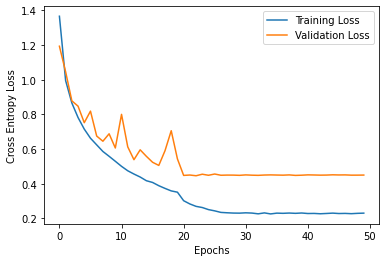

In [35]:
import matplotlib.pyplot as plt 

train_acc_list = np.load("train_acc_list.npy", allow_pickle=True)
val_acc_list = np.load("val_acc_list.npy", allow_pickle=True)
train_acc_list = np.load("train_loss_list.npy", allow_pickle=True)
val_acc_list = np.load("val_loss_list.npy", allow_pickle=True)


fig = plt.figure()
plt.plot(np.arange(50), train_acc_list, label="Training Accuracy")
plt.plot(np.arange(50), val_acc_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.png", dpi=300)
plt.clf()

fig = plt.figure()
plt.plot(np.arange(50), train_loss_list, label="Training Loss")
plt.plot(np.arange(50), val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.savefig("loss.png", dpi=300)

# Load Model for Saved Evaluations

In [56]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from scipy.special import softmax

train_iterator, val_iterator, test_iterator = load_data(BATCH_SIZE=1028)
criterion = nn.CrossEntropyLoss()
# test model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'comp_med_resnet.pt'
SAVE_DIR = "drive/MyDrive/"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
print("loading model...")
trained = models.resnet50(num_classes=9)
checkpoint = torch.load(MODEL_SAVE_PATH)
trained.load_state_dict(checkpoint)
trained.to(device)


def report_metrics(iterator):
  trained.eval()
  avg_auc = list()
  avg_acc = list()
  avg_auroc = list()
  with torch.no_grad():
    for (x, y) in tq.tqdm(iterator, leave=False):
      x = x.to(device)
      fx = trained(x)
      preds = fx.max(1, keepdim=True)[1]
      acc = calculate_accuracy(fx, y.to(device))
      acc = acc.cpu().numpy()
      avg_acc.append(acc)
      preds = preds.cpu().numpy()
      batch_probs = list()
      for i in range(len(x)):
        probs = (softmax(fx[i].cpu().numpy()))
        batch_probs.append(probs)
      avg_auroc.append(roc_auc_score(y.cpu().numpy(), batch_probs, multi_class='ovr'))
      # treat cancer as positive label
      y = np.where(y == 8, 1, 0)
      avg_auc.append(average_precision_score(y, preds))
    return (sum(avg_auc)/len(avg_auc)), (sum(avg_acc)/len(avg_acc)), (sum(avg_auroc)/len(avg_auroc))

# auc, acc, auroc = report_metrics(train_iterator)
# print(auc, acc, auroc)
auc, acc, auroc = report_metrics(val_iterator)
print(auc, acc, auroc)
auc, acc, auroc = report_metrics(test_iterator)
print(auc, acc, auroc)

loading model...


  0%|          | 0/10 [00:00<?, ?it/s]

0.7302937637984463 0.8447884738445282 0.9844235714152407


  0%|          | 0/7 [00:00<?, ?it/s]

0.6162444304188279 0.6899957742009845 0.9398496517192078


# Model Interpretation

In [ ]:
! pip install shap
import matplotlib.pyplot as plt
import shap
import numpy as np 

def load_data_shap(BATCH_SIZE):
  # load into numpy array
  images = np.load("/content/drive/MyDrive/pathmnist.npz")
  Xtrain = images["train_images"]
  Xval = images["val_images"]
  Xtest = images["test_images"]
  ytrain = torch.from_numpy(images["train_labels"].flatten()).long()
  yval = torch.from_numpy(images["val_labels"].flatten()).long()
  ytest = torch.from_numpy(images["test_labels"].flatten()).long()
  # load into dataset
  train_data = PathDataset(Xtrain, ytrain)
  val_data = PathDataset(Xval, yval)
  test_data = PathDataset(Xtest, ytest)
  # load batches
  train_dl = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
  val_dl = DataLoader(val_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  test_dl = DataLoader(test_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  return train_dl, val_dl, test_dl

train_iterator, val_iterator, test_iterator = load_data_shap(BATCH_SIZE=1028)

for (x, y) in train_iterator:
  shap_imgs = x
  shap_img_labs = y
  break
for (x, y) in val_iterator:
  shap_test_imgs = x
  shap_test_img_labs = y
  break

trained.to(device)
background = (shap_imgs[np.random.choice(shap_imgs.shape[0], 100, replace=False)]).cuda()
print(background.shape)
e = shap.DeepExplainer(trained, background)
print(e.shap_values)
print(shap_test_imgs[:5].shape)
shap_values = e.shap_values(shap_test_imgs[0:5].cuda())
shap.image_plot(shap_values, -shap_test_imgs[0:5].reshape(1, 3, 64, 64))

torch.Size([100, 3, 32, 32])
<bound method Deep.shap_values of <shap.explainers._deep.Deep object at 0x7f8c06a25550>>
torch.Size([5, 3, 32, 32])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: ignored